In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Collecting data
texts=pd.read_csv('Data/base_csv_final.csv')
d_titles=texts['Title'].to_dict()
data=pd.read_parquet('Data/info.parquet', engine='pyarrow')

In [26]:
#mean number of words
np.mean([len(df) for df in data])

np.float64(4841.666666666667)

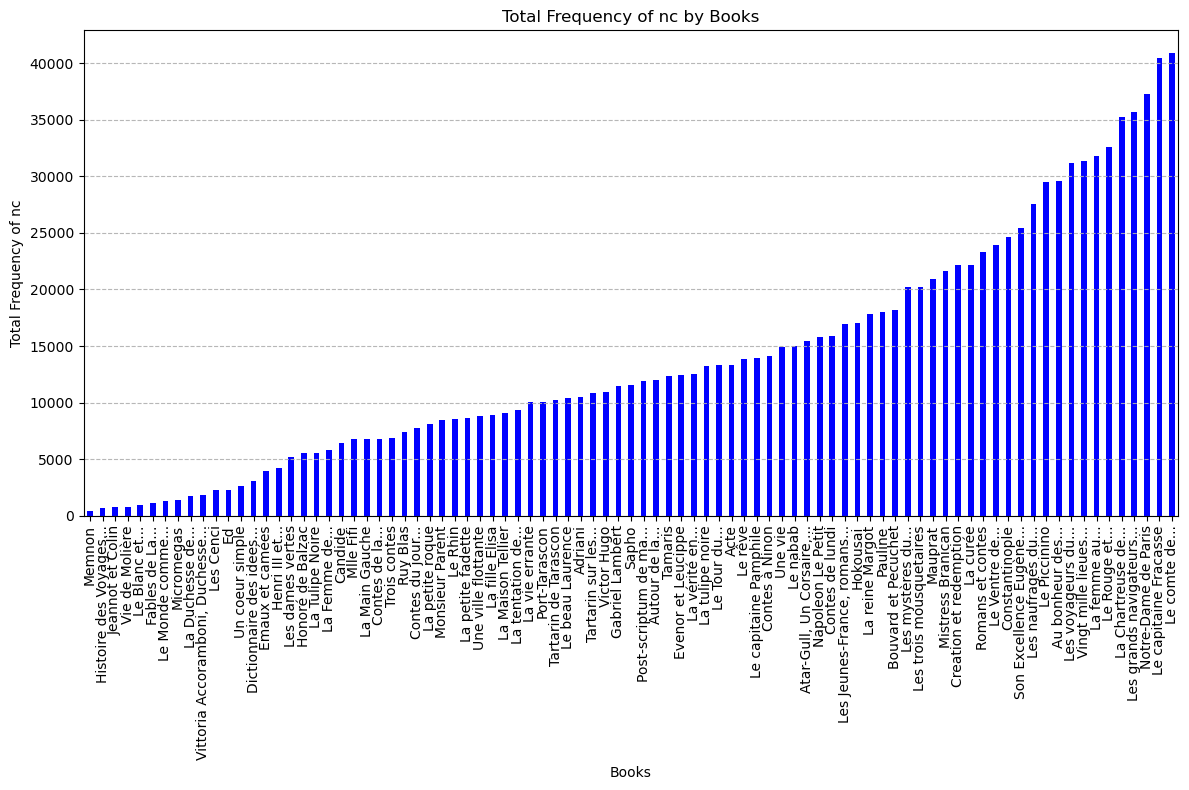

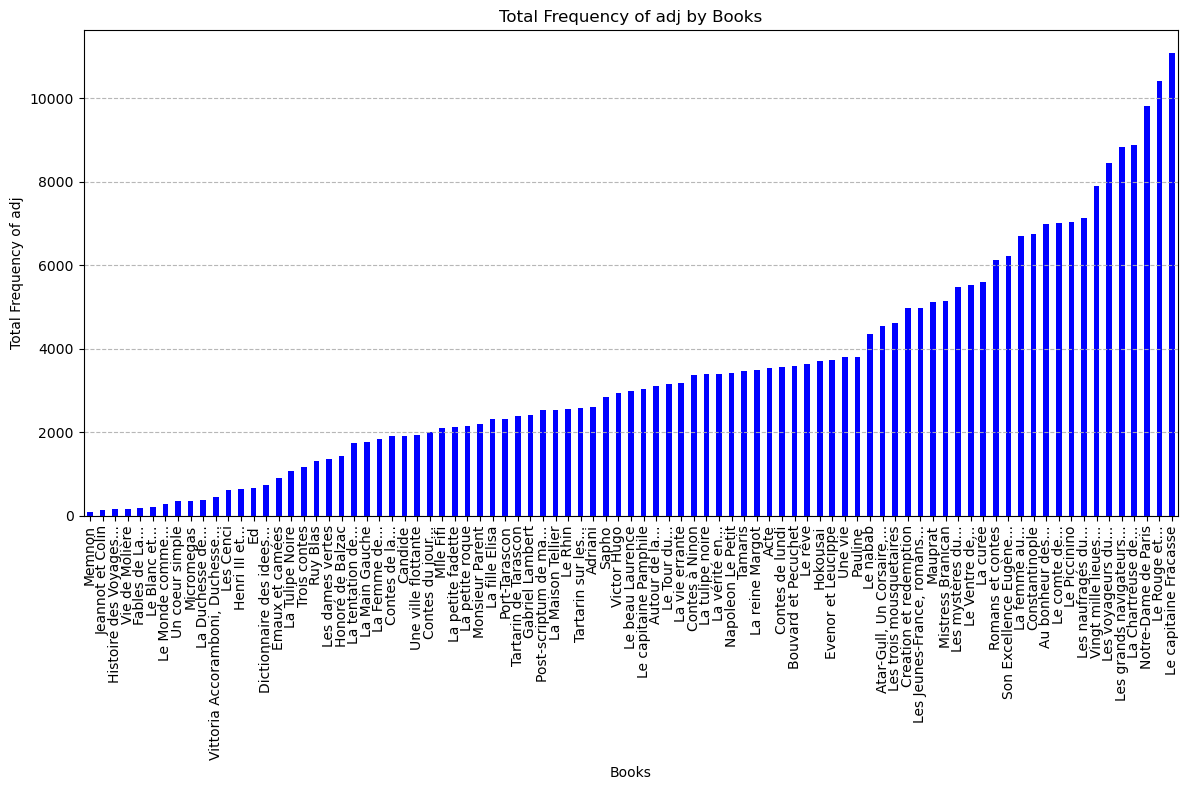

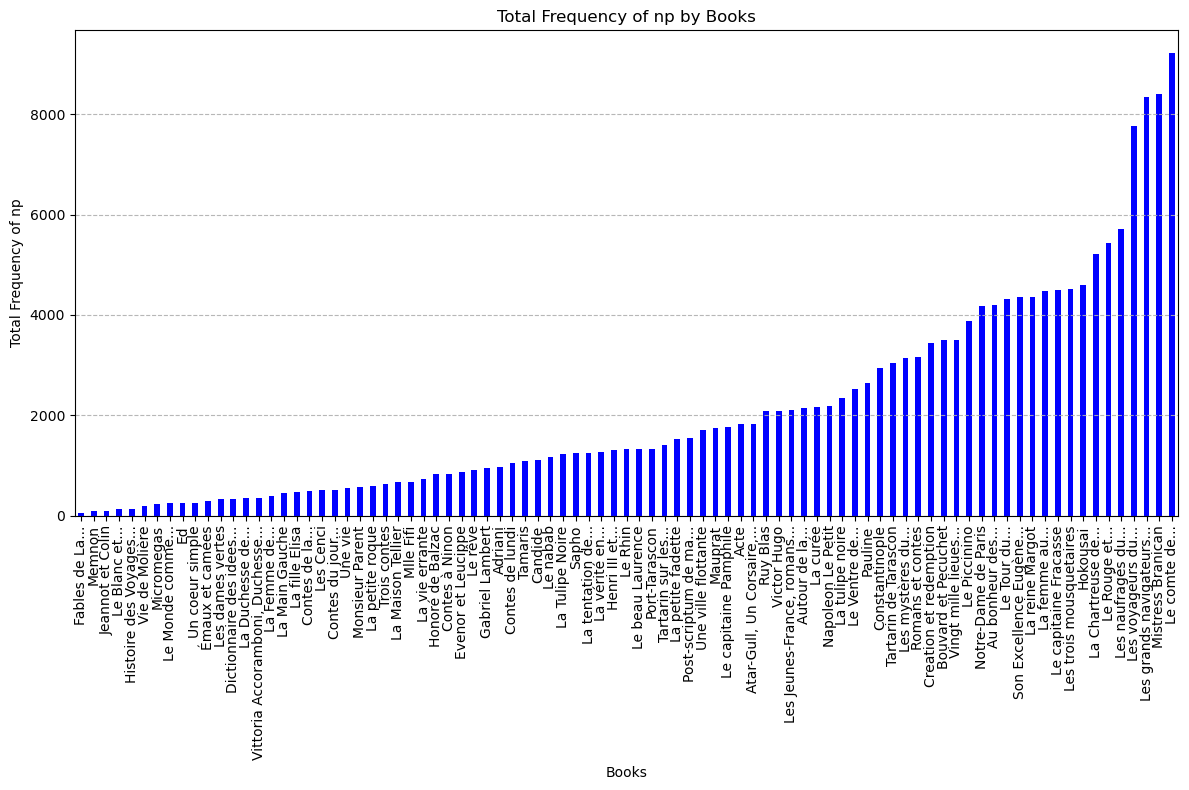

In [44]:
for w_type in ['nc','adj','np'] :

    #Tri de data en fonction du type
    df_sorted = data[data['Type'] == w_type]

    #Somme des fréquences des mots de ce type par livre
    df_sum= df_sorted.groupby('Id')['Freq'].sum()
    d_freq = {
        #Ne retient que les 3 premiers mots de d_titles et ajoute '...' si le titre est plus long
        ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): freq
        for book_id, freq in df_sum.items()
    }
    #Tri pour avoir des valeurs croissantes
    d_freq_sorted = dict(sorted(d_freq.items(), key=lambda item: item[1]))
    #Taille du graph
    plt.figure(figsize=(12, 8))
    #Répartition des positions pour l'axe des abscisses
    x_positions = np.arange(len(d_freq_sorted))*2
    #Tracé des barres
    plt.bar(x_positions, list(d_freq_sorted.values()), color='blue', width=0.9)
    #Titre et labels des axes
    plt.title(f'Total Frequency of {w_type} by Books')
    plt.xlabel('Books')
    plt.ylabel(f'Total Frequency of {w_type}')
    #Ajout d'une grille honrizontale
    plt.grid(True, axis='y', linestyle='--', alpha=0.9)
    #Limites de l'axe des abscisses
    plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
    #Paramètres des abscisses 
    plt.xticks(x_positions, list(d_freq_sorted.keys()), rotation=90, ha='center', fontsize=10) 
    #Affichage (tight_layout pour un rendu plus propre)
    plt.tight_layout()
    plt.show()


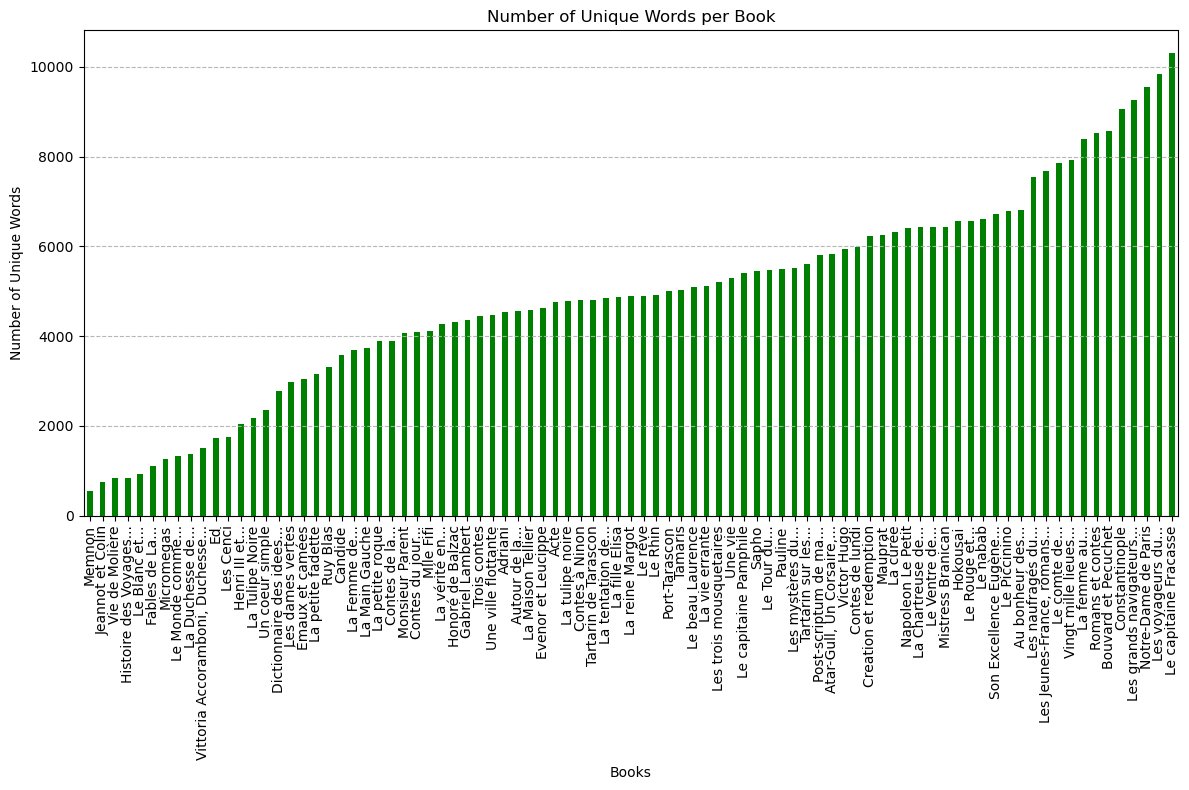

In [47]:
import matplotlib.pyplot as plt
import numpy as np

#Nombre de mots différents par livre
w_unique = data.groupby('Id')['Word'].nunique()

#Titre avec seulement les 4 premiers mots et nombre de mots unique
d_unique = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in word_counts_per_book.items()
}

#Tri par valeurs croissantes
d_unique_sorted = dict(sorted(d_unique.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_unique_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_freq_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_unique_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Number of Unique Words per Book')
plt.xlabel('Books')
plt.ylabel('Number of Unique Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_unique_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()


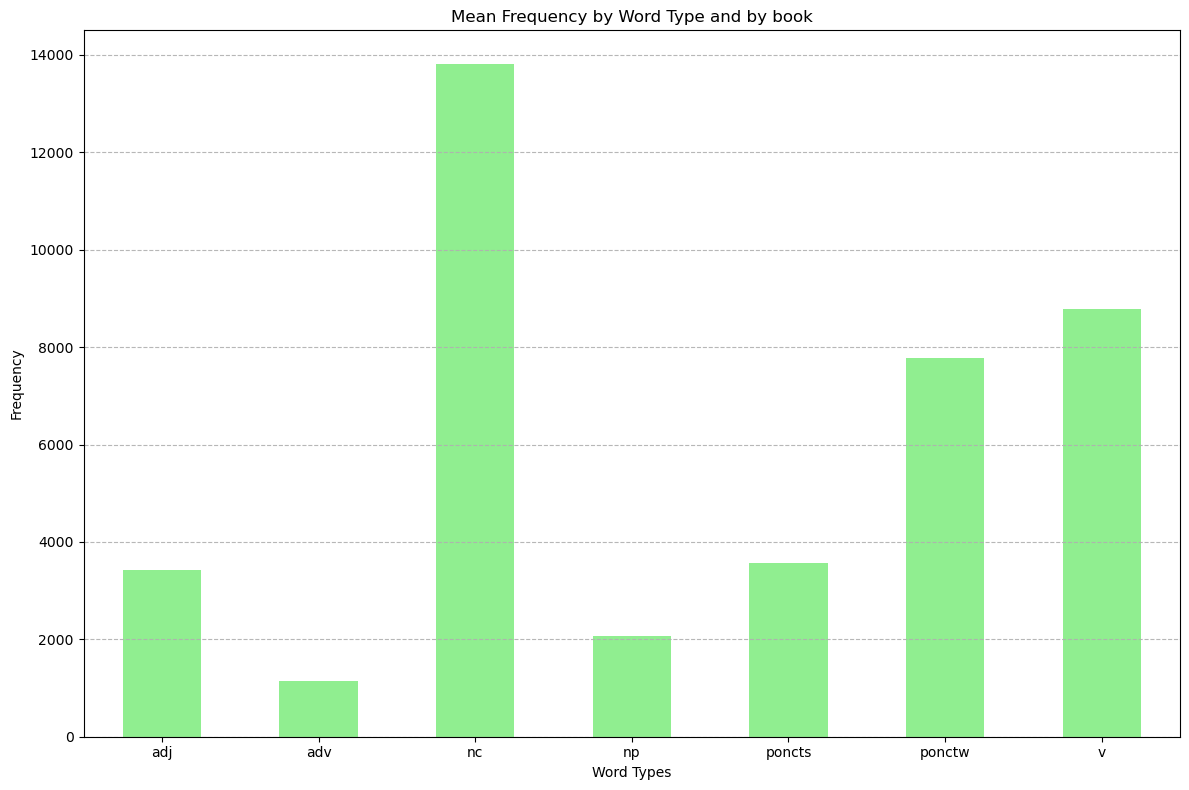

In [42]:
#Somme des fréquences par livre et type
df_stats = data.groupby(['Id', 'Type'])['Freq'].sum().reset_index()
#Récupération des moyenns par type
df_stats = df_stats.groupby('Type')['Freq'].mean()

#Liste des principeaux types de mots
l_included = ['nc', 'v', 'adj', 'np', 'adv', 'ponctw','poncts']

#Filtrage pour ne garder que les types voulus
df_filtered = df_stats[df_stats.index.isin(l_included)]

# Step 3: Plot the results
df_filtered.plot(kind='bar', figsize=(12, 8), color=['lightgreen'])

#Titre et labels des axes
plt.title('Mean Frequency by Word Type and by book')
plt.xlabel('Word Types')
plt.ylabel('Frequency')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Abscisses mises à l'horizontal
plt.xticks(rotation=0)
#Affichage
plt.tight_layout()
plt.show()

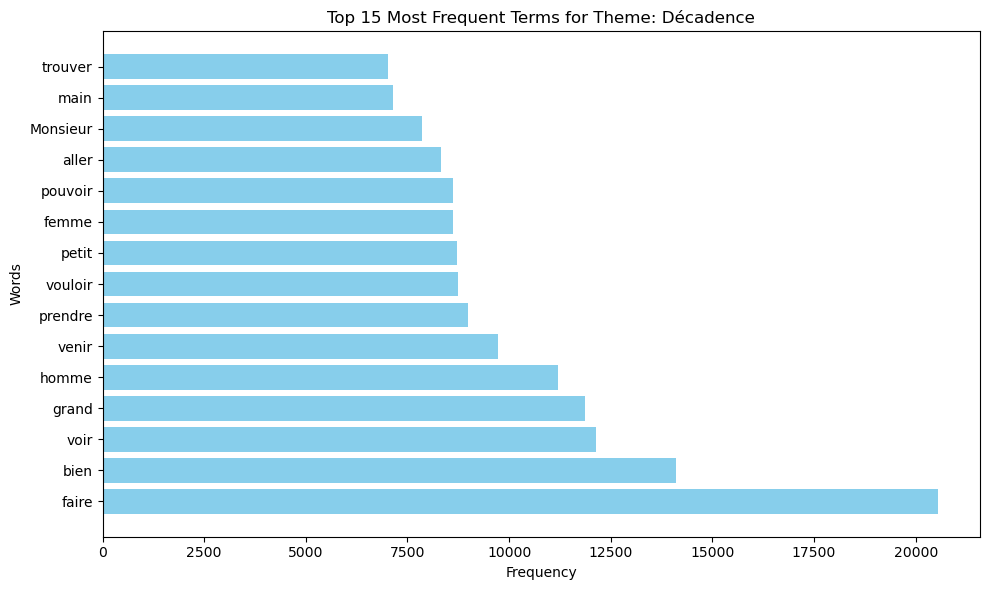

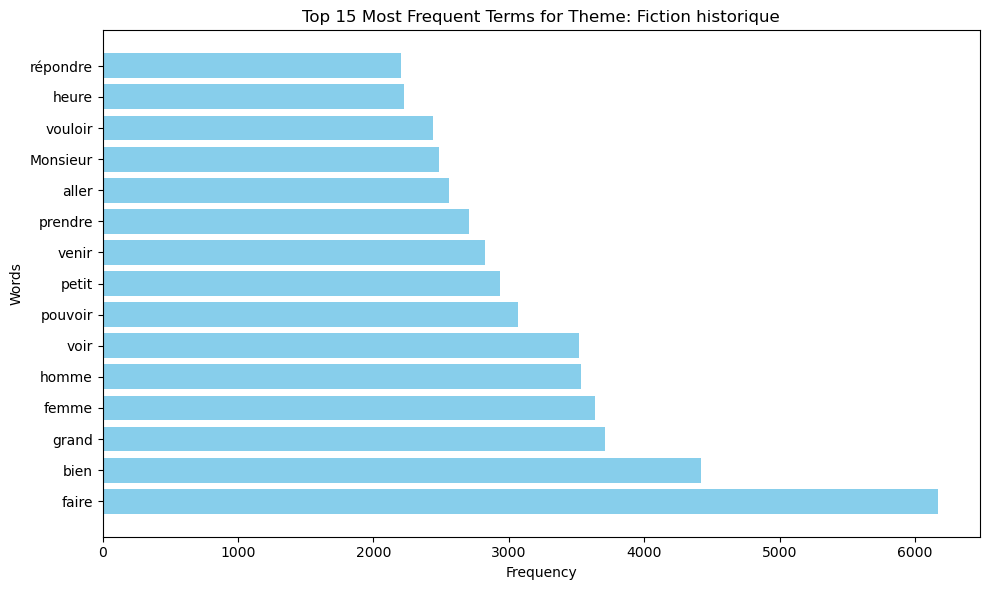

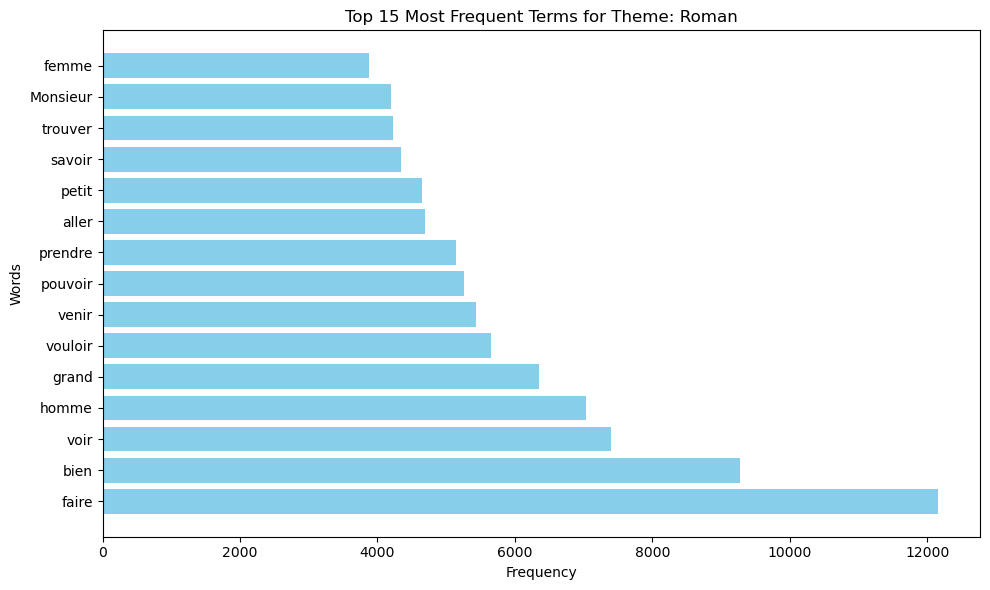

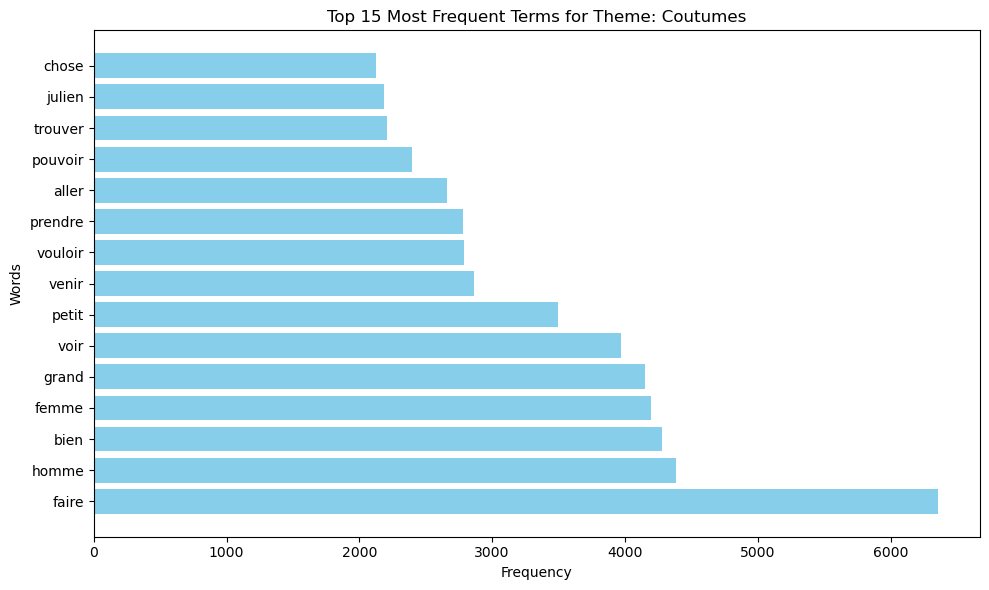

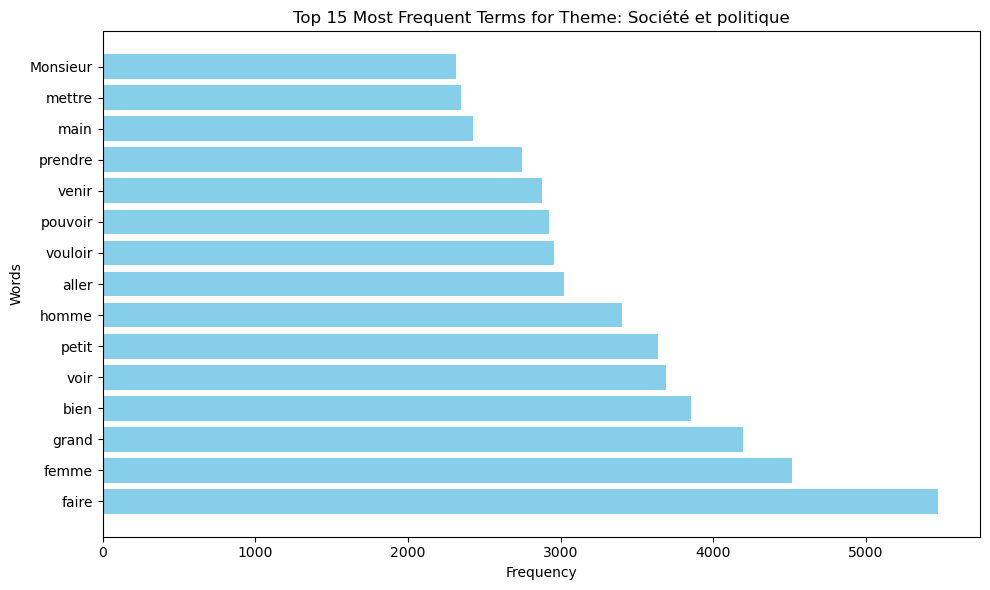

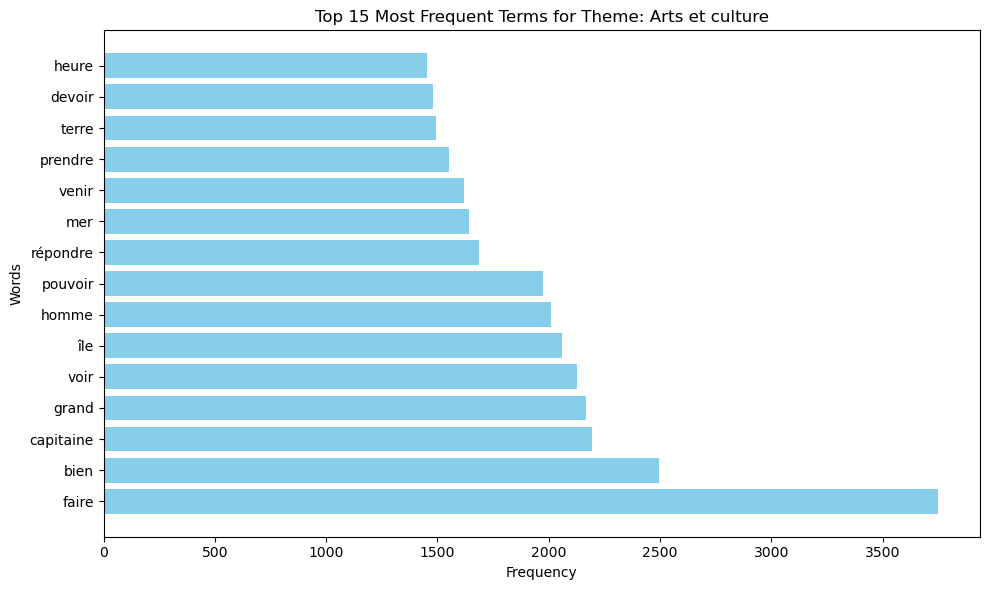

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

#Création d'un dictionaire (avec des valeurs par défaut il y a des valeurs manquantes)
d_freq = defaultdict(lambda: defaultdict(int))
#Types de mots retenus
include_types = ['nc', 'v', 'adj', 'np', 'adv']

total_word_freq = defaultdict(int)
word_theme_count = defaultdict(int)

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type in include_types:
            total_word_freq[word] += freq
            for theme in themes:
                word_theme_count[word] += 1

top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):
            if word_type in include_types and word not in top_20_words and word not in exclude_words:
                freq = float(freq)
                d_freq[theme.strip().lower()][word] += freq

themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"]

for theme, word_freqs in d_freq.items():
    if theme in [t.lower() for t in themes_to_plot]:
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


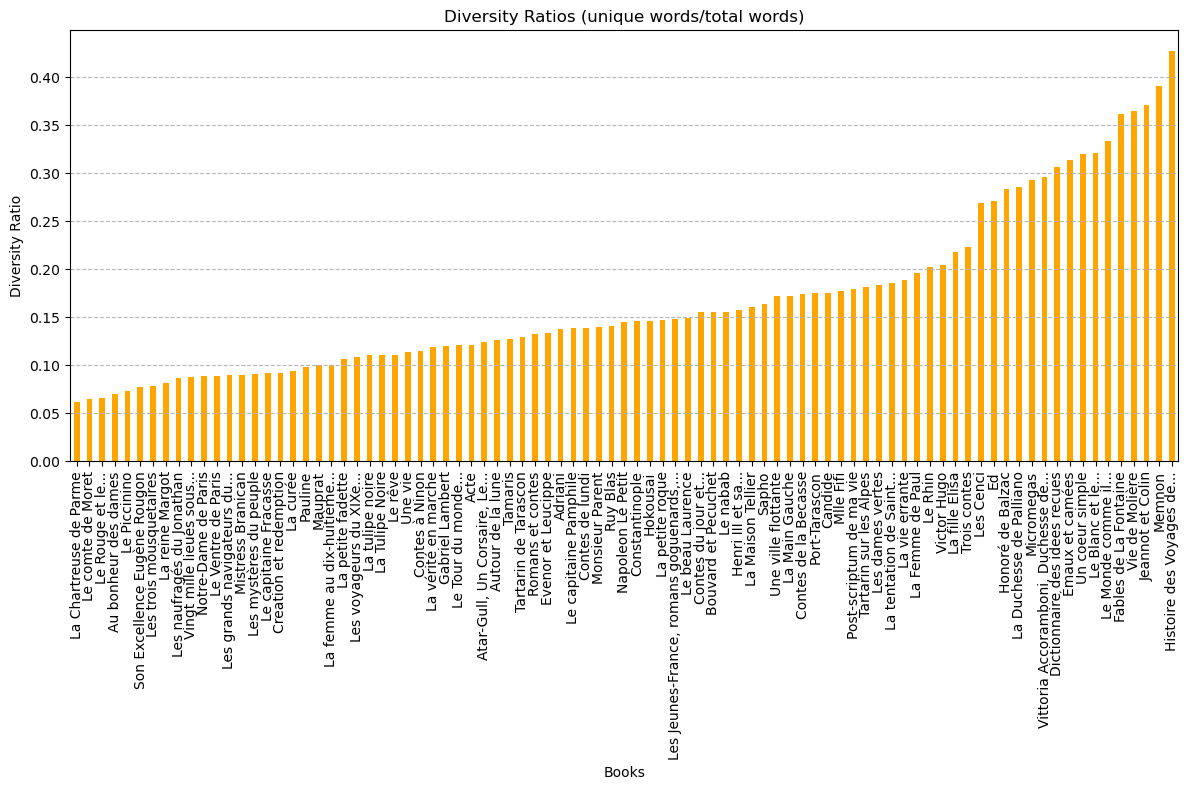

In [40]:
import numpy as np
import matplotlib.pyplot as plt

#Nombre de mots total par livre et nombre de mots différent
w_total= data.groupby('Id')['Freq'].sum()  
w_unique = data.groupby('Id')['Word'].nunique() 

# Coefficient de diversité (nombre de mots différents/nombre de mots total)
diversity_ratio = (w_unique / w_total).sort_values()


#Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
l_books =  [' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else '') for book_id in diversity_ratio.index]


#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(diversity_ratio)) * 2
#Tracé des barres
plt.bar(x_positions, diversity_ratio, color='orange', width=0.9)
#Titre et labels des axes
plt.title('Diversity Ratios (unique words/total words)')
plt.xlabel('Books')
plt.ylabel('Diversity Ratio')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, l_books, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

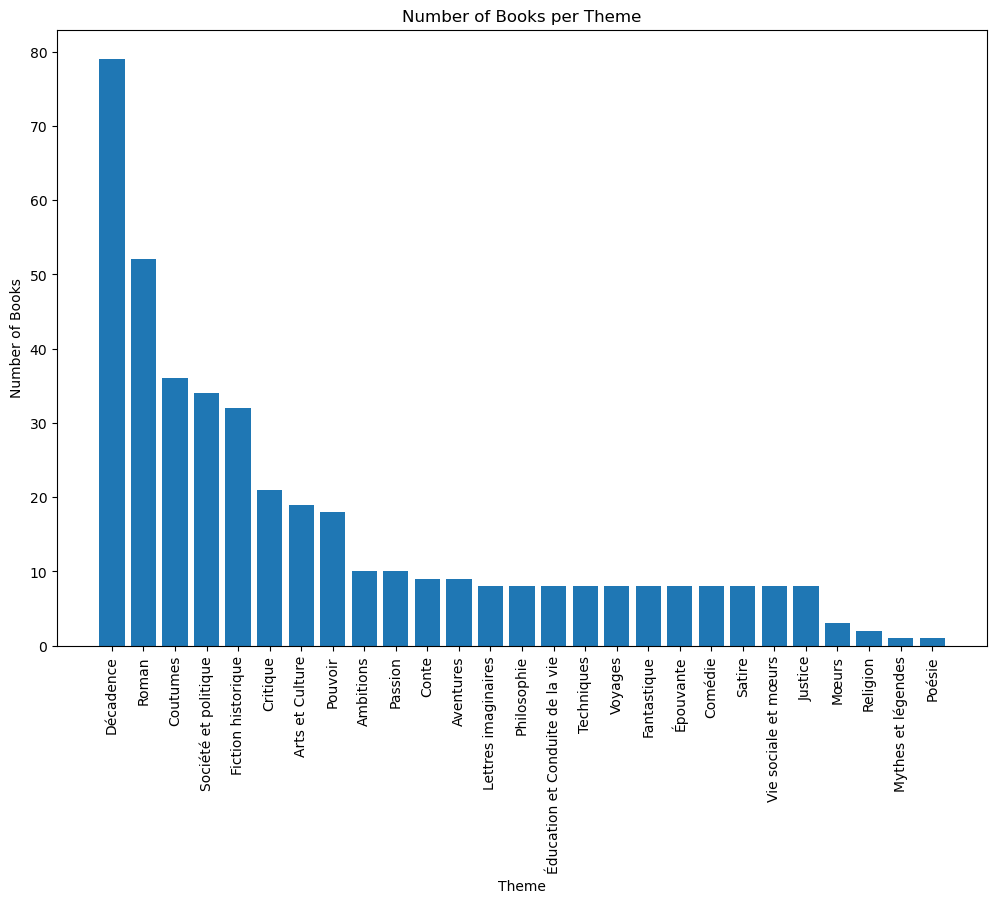

In [55]:
#Séparation des thèmes en listes si les thèmes sont sous forme d'un unique string
texts['Themes'] = texts['Themes'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

#Création de lignes spullémentaires pour qu'il n'y ait plus que un thème par ligne
texts_exploded = texts.explode("Themes")

#Nombre de livres par thème dans un dataframe
df_counts = texts_exploded['Themes'].value_counts().reset_index()
df_counts.columns = ['Theme', 'Number of Books']


#Taille graph
plt.figure(figsize=(12, 8))
#Tracé des barres
plt.bar(df_counts['Theme'], df_counts['Number of Books'])
#Titre et labels des axes
plt.xlabel('Theme')
plt.ylabel('Number of Books')
plt.title('Number of Books per Theme')
#Abscisses à l'horizontal
plt.xticks(rotation=90, fontsize=10)
#Affichage
plt.show()

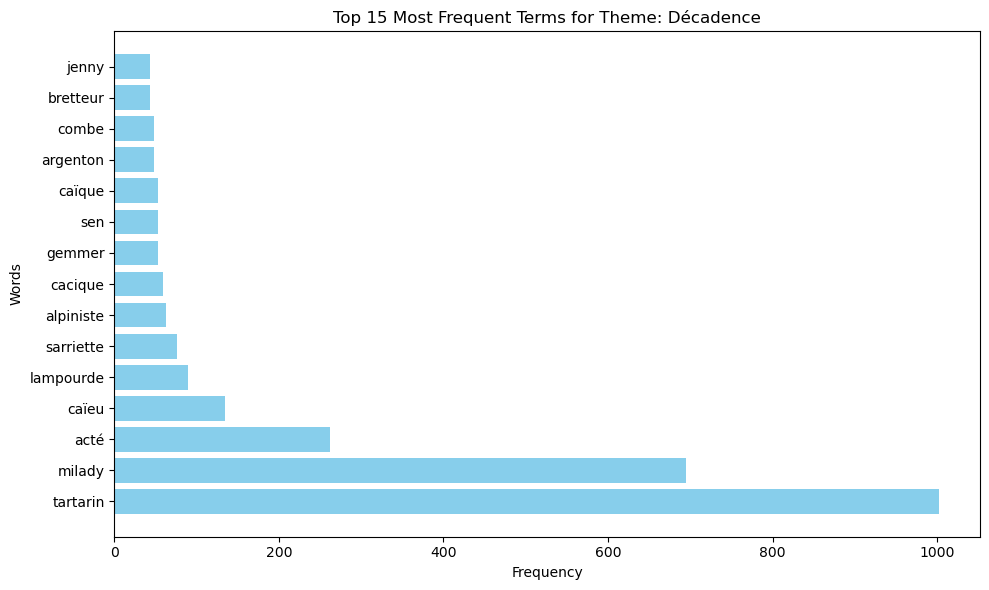

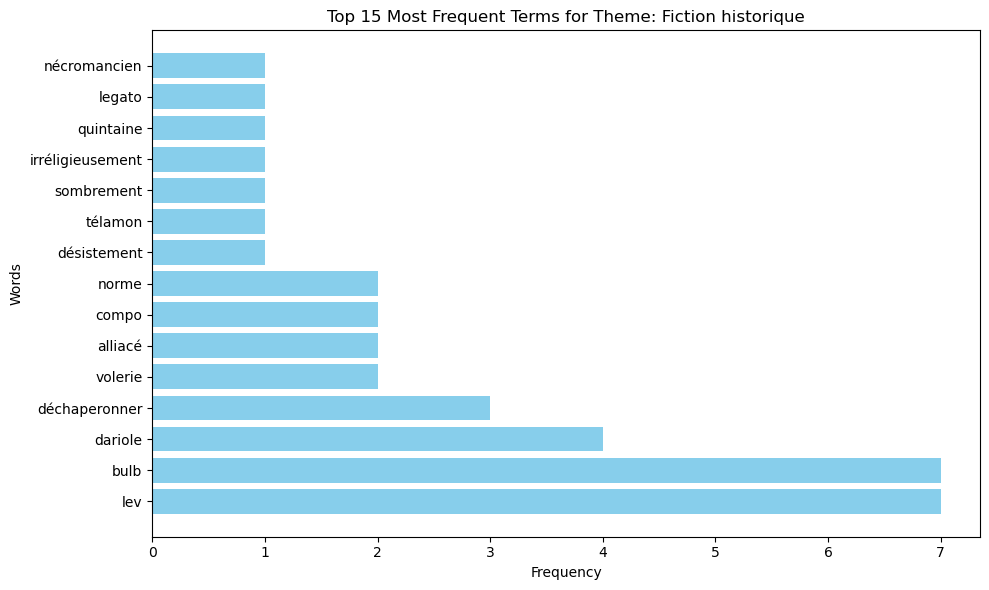

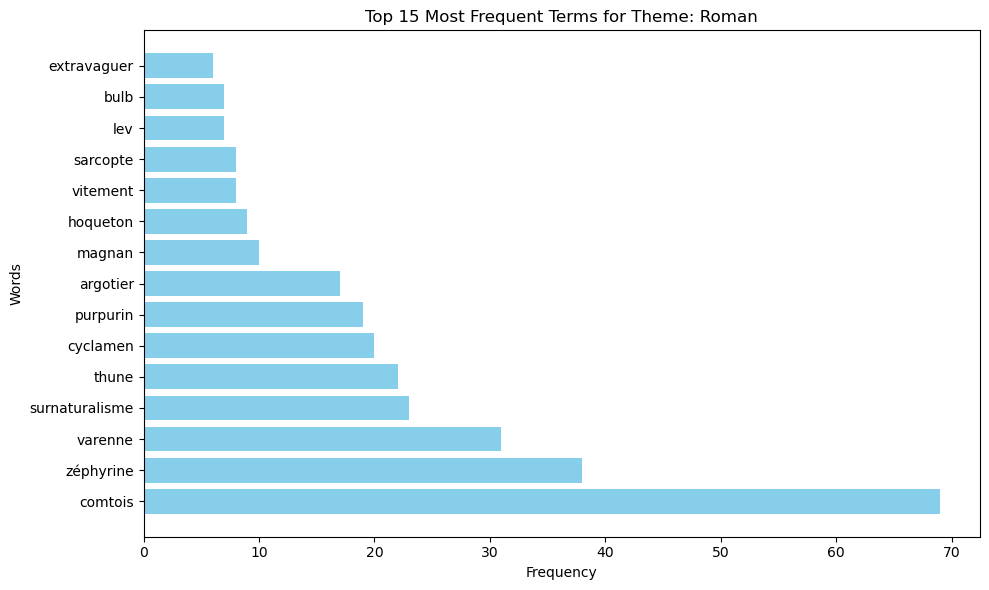

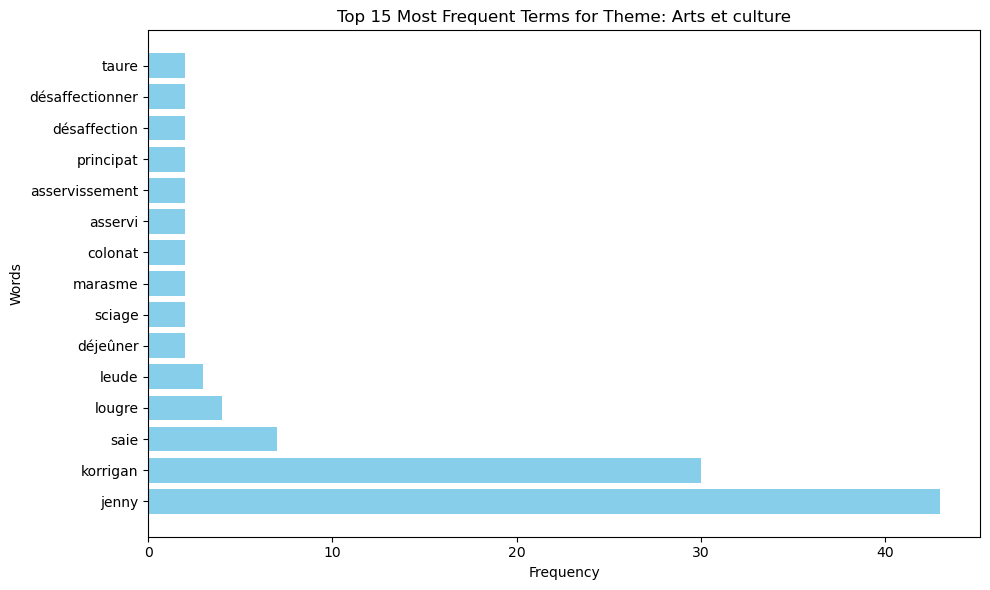

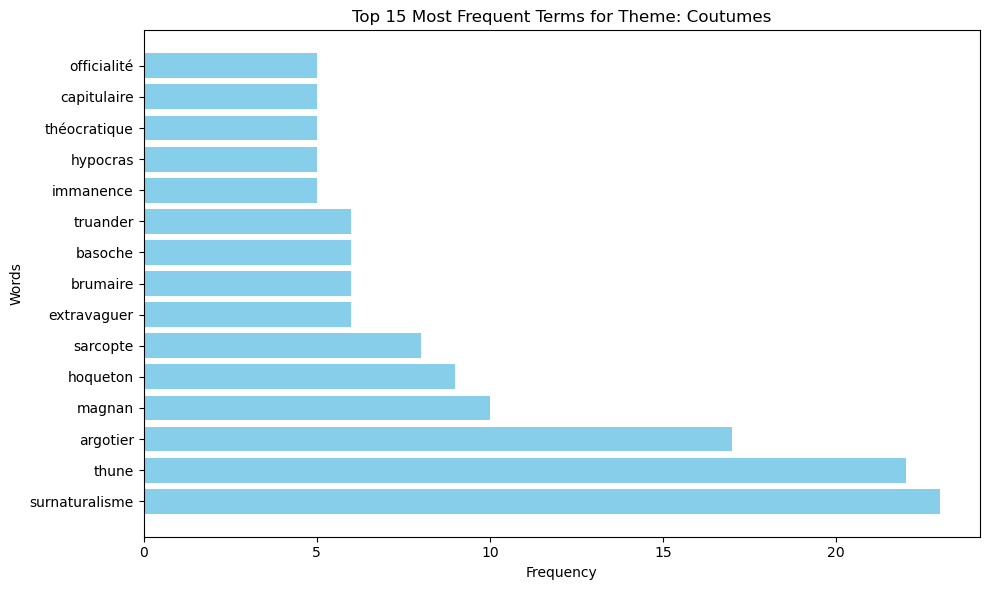

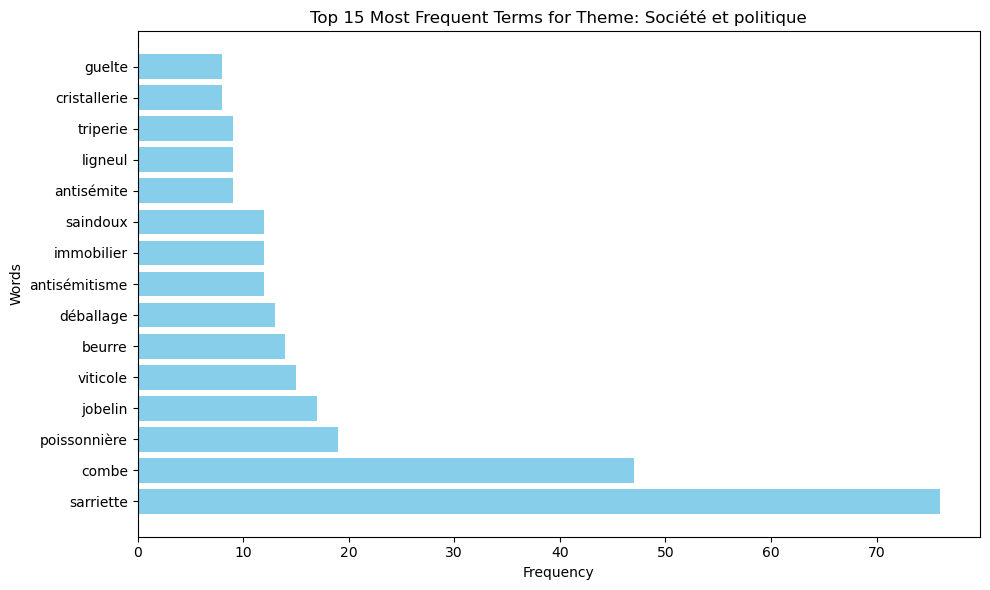

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Create a dictionary to store word frequencies for each theme
theme_word_freq = defaultdict(lambda: defaultdict(int))

# Set the types of words you want to exclude (e.g., 'punctuation' and 'stopword')
exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

# Step 2: Calculate the total word frequencies across all books to identify the top 20 most frequent words
total_word_freq = defaultdict(int)

# Create a dictionary to track in how many themes each word appears
word_theme_count = defaultdict(int)

# Step 3: Loop through each book in 'texts' and update the total word frequencies and theme counts
for idx, row in texts.iterrows():
    # Get the book title and themes for the current row
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    # Get the corresponding book Id from the current row (idx)
    book_id = idx  # 'idx' is the row number in texts, which corresponds to the 'Id' in data
    
    # Filter the 'data' dataframe using the book Id
    book_df = data[data['Id'] == book_id]
    
    # Get the words, frequencies, and types from the respective columns
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    # Update total word frequency for all words across all books
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:  # Only consider valid types
            total_word_freq[word] += freq
            
            # Count in how many themes the word appears
            for theme in themes:
                word_theme_count[word] += 1

# Step 4: Get the top 20 most frequent words across all books
top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}

# Step 5: Identify words that appear in strictly more than 2 themes
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

# Step 6: Calculate word frequencies for each theme across all books, excluding top 20 frequent words and words in more than 2 themes
for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    # Get the corresponding book Id from the current row (idx)
    book_id = idx  # 'idx' is the row number in texts, which corresponds to the 'Id' in data
    
    # Filter the 'data' dataframe using the book Id
    book_df = data[data['Id'] == book_id]
    
    # Get the words, frequencies, and types from the respective columns
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    # For each theme, add the word frequencies to the theme's frequency dictionary
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):  # Map words, frequencies, and types
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:  # Exclude top 20 and words in > 2 themes
                # Directly convert freq to float (removing the try-except block)
                freq = float(freq)  # Convert freq to float if it's not already a number
                theme_word_freq[theme.strip().lower()][word] += freq  # Strip and convert theme to lowercase to avoid duplication

# Step 8: Define the list of themes you want to plot (ensure they match exactly)
themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"] # Replace with your actual theme names, make sure they're in lowercase and match exactly

# Step 9: Plot the 15 most frequent terms for the specified themes only
for theme, word_freqs in theme_word_freq.items():
    # Check if the theme is in the list of themes to plot
    if theme in [t.lower() for t in themes_to_plot]:  # Ensure case-insensitive matching
        # Sort words by frequency (descending)
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        
        # Prepare data for plotting
        words, freqs = zip(*sorted_words)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


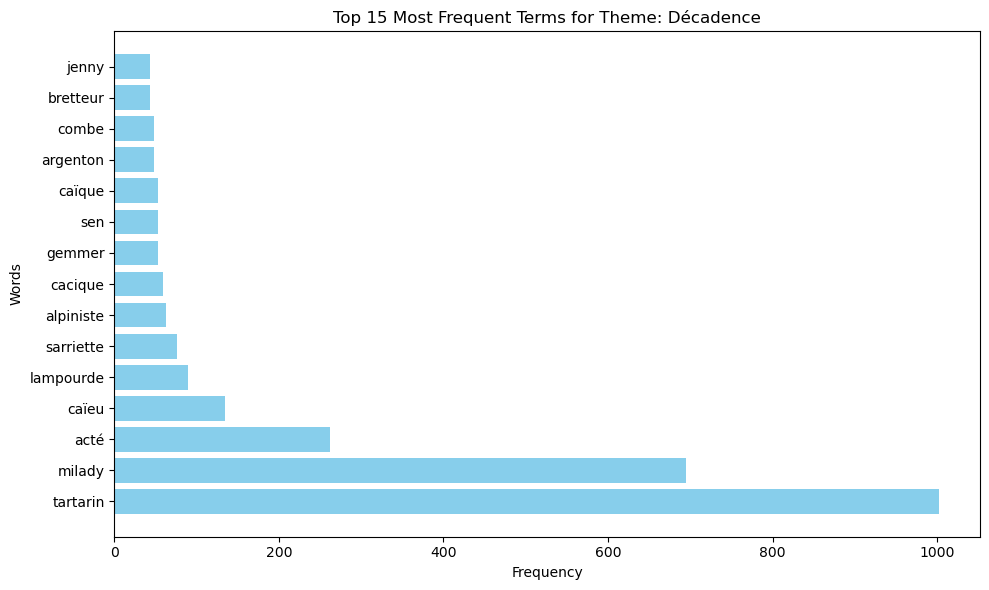

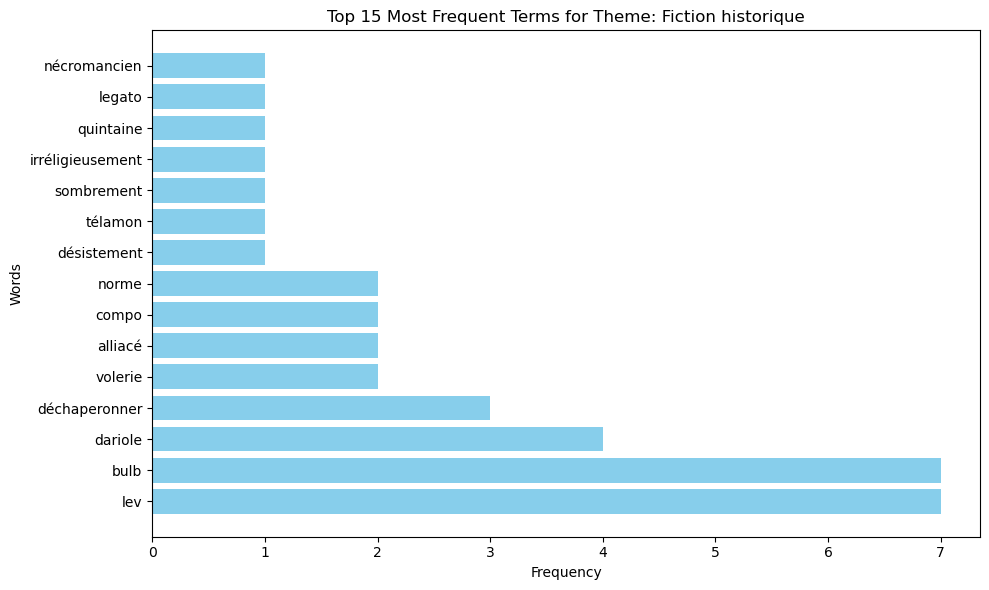

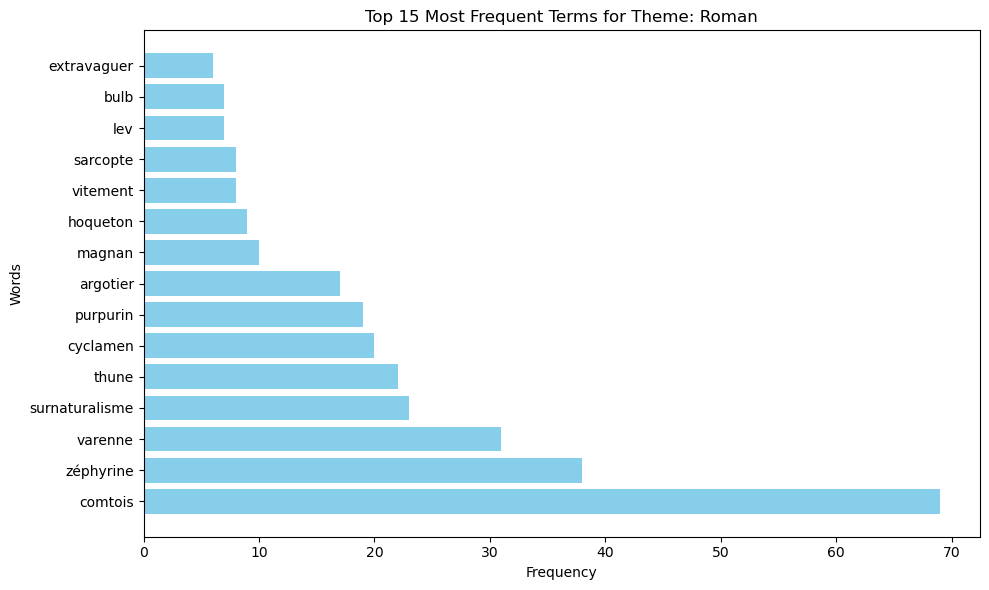

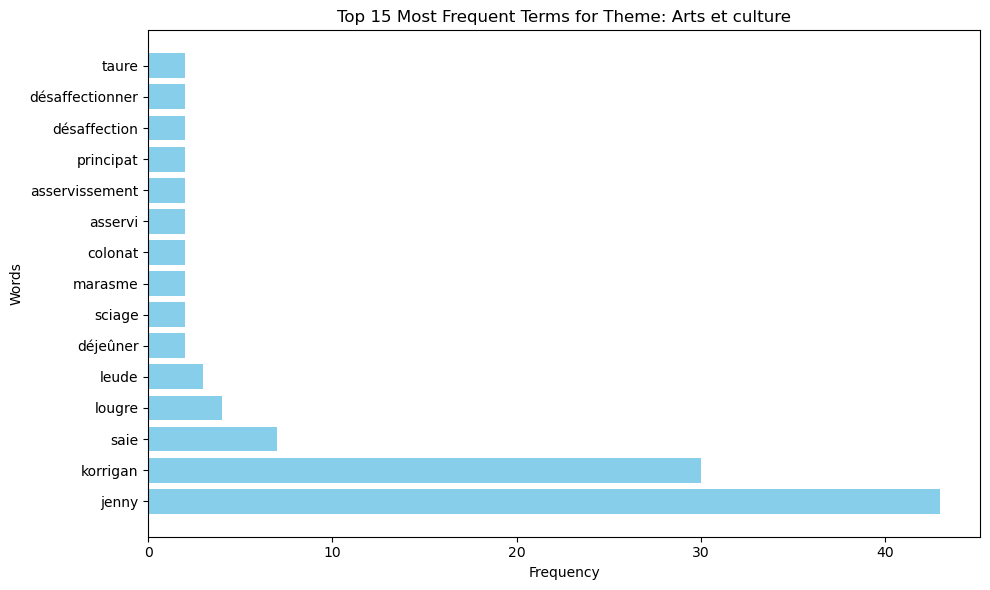

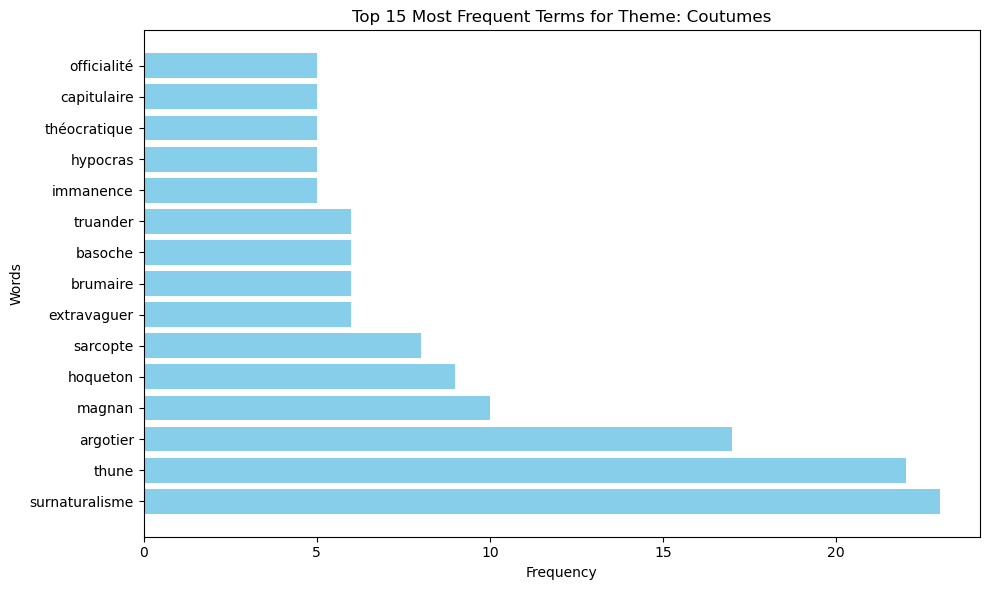

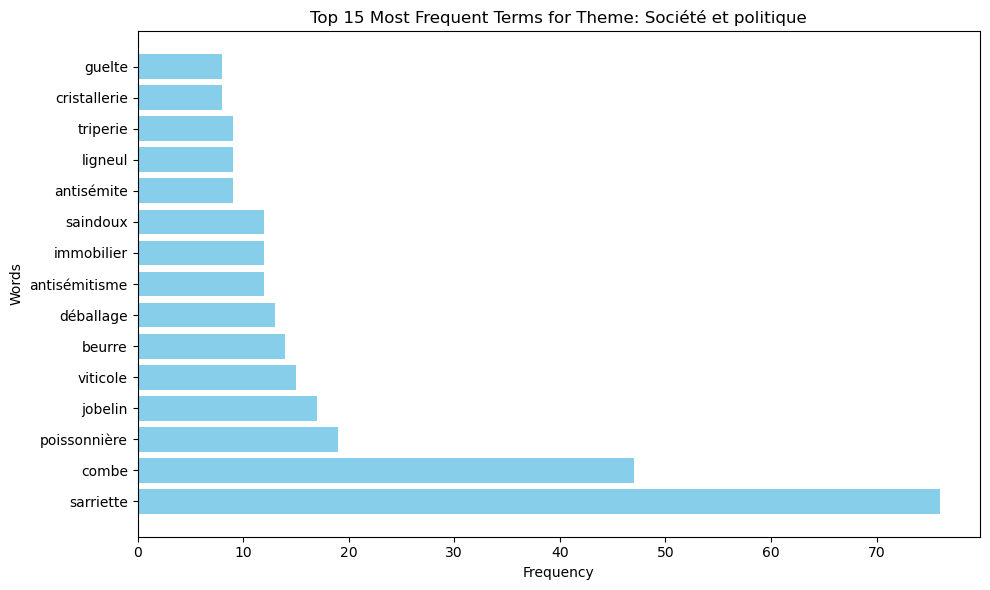

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

theme_word_freq = defaultdict(lambda: defaultdict(int))

exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

total_word_freq = defaultdict(int)
word_theme_count = defaultdict(int)

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:
            total_word_freq[word] += freq
            for theme in themes:
                word_theme_count[word] += 1

top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:
                freq = float(freq)
                theme_word_freq[theme.strip().lower()][word] += freq

themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"]

for theme, word_freqs in theme_word_freq.items():
    if theme in [t.lower() for t in themes_to_plot]:
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


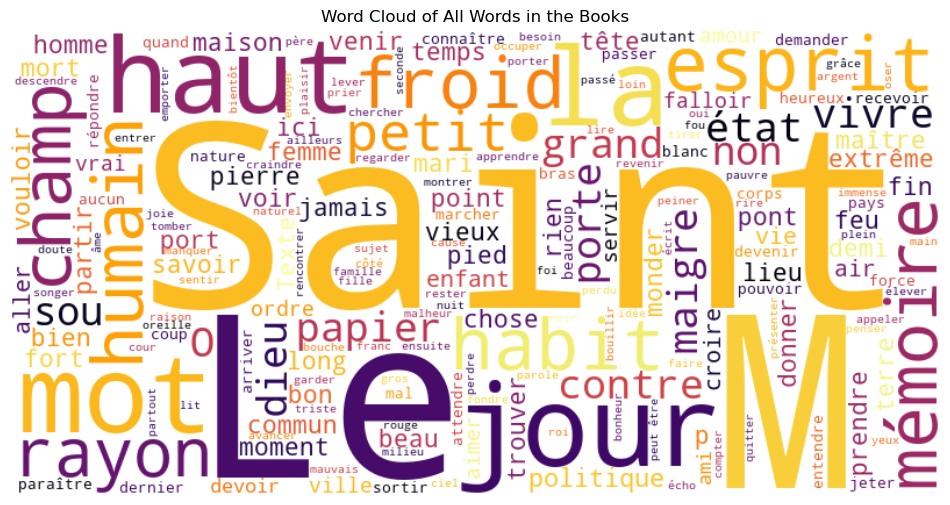

In [51]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Rassemble tous les mots dans data 
all_words = " ".join(data['Word'].astype(str))

#Création du nuage à partir des mots de data
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(all_words)

#Taille graph
plt.figure(figsize=(12, 8))
#Dessin du nuage
plt.imshow(wordcloud, interpolation='bilinear')
#Retrait des axes
plt.axis('off')
#Titre
plt.title('Word Cloud of All Words in the Books')
#Affichage
plt.show()


) missing from font(s) DejaVu Sans.37: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.ages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


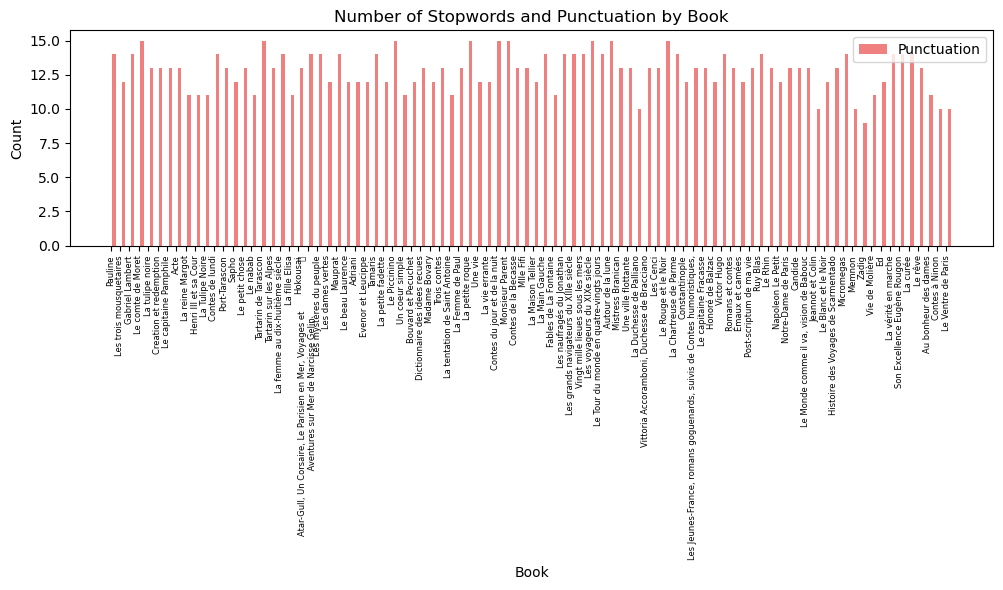

In [87]:
#pb car 47 vide probablement
import spacy
combined_df = pd.concat(l_data, ignore_index=True)

nlp = spacy.load("fr_core_news_sm")  #modèle français
stop_words_fr = nlp.Defaults.stop_words #liste de stopwords fr

# Step 2: Define a function to count stopwords and punctuation
def count_stopwords_punctuation(df, punctuation_types):
    punctuation_count = df[df['Type'].isin(punctuation_types)].shape[0]
    return punctuation_count

# Step 3: Count stopwords and punctuation for each dataframe (book)
punctuation_count = []
books = d_titles.values()

for df in l_data:
    punctuation_count_value = count_stopwords_punctuation(df, ["epsilon","ponctw","poncts","parento","parentf"])
    punctuation_count.append(punctuation_count_value)

# Step 4: Plot the results

# Bar plot for stopwords and punctuation counts
x = range(len(l_data))
width = 0.35  # The width of the bars

plt.figure(figsize=(10, 6))
plt.bar([p + width for p in x], punctuation_count, width, label='Punctuation', color='lightcoral')

# Customizing the plot
plt.title('Number of Stopwords and Punctuation by Book')
plt.xlabel('Book')
plt.ylabel('Count')
plt.xticks(ticks=range(len(books)), labels=books,rotation=90,fontsize=6)  # Position x-ticks at the center of bars
plt.legend()

plt.tight_layout()

# Show the plot
plt.show()


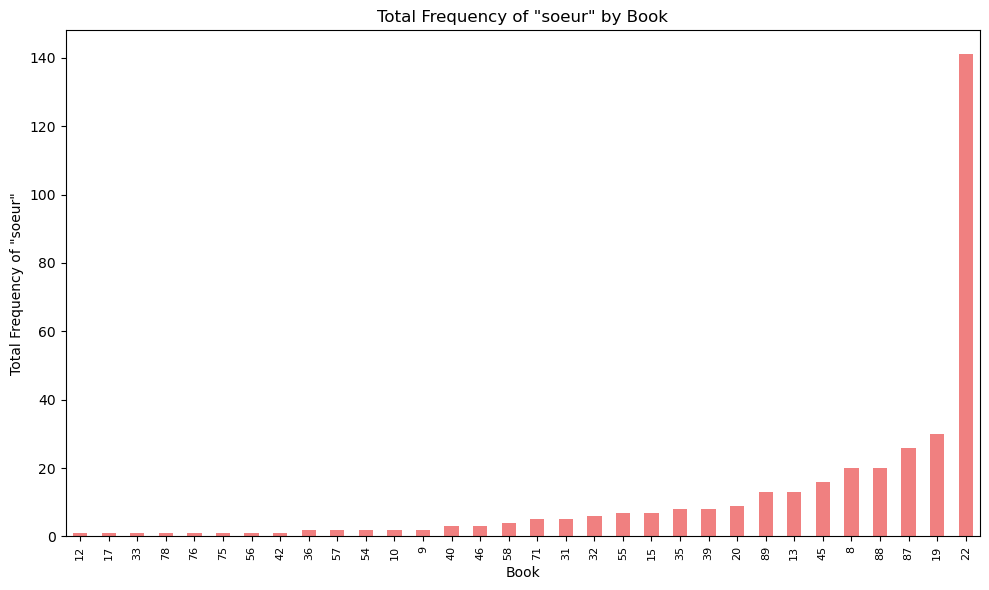

In [124]:
combined_df = pd.concat(l_data, ignore_index=True)

# Step 2: Filter the combined dataframe to only include the word "beautiful"
word_of_interest = "soeur"
word_df = combined_df[combined_df['Word'] == word_of_interest]

# Step 3: Sum the frequency of the word for each book
frequency_by_book = word_df.groupby('Id')['Count'].sum()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
frequency_by_book.sort_values().plot(kind='bar', color='lightcoral')

# Customizing the plot
plt.title(f'Total Frequency of "{word_of_interest}" by Book')
plt.xlabel('Book')
plt.ylabel(f'Total Frequency of "{word_of_interest}"')
plt.xticks(rotation=90, ha='center',fontsize=8)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
